## $\mathbf{E}\times \mathbf{B}$ Drift
2D simulations of Single Particle Drifts
***

#### About the simulation

We will be using the 2D version of **ZPIC**. With this particle in cell code we are required to initialize a full plasma instead of a single particle. However, we may still track single particles and eliminate collective effects by decreasing the plasma density.

* Creating a plasma with custom density
```python
ppc = [8,8]
dens=em2d.Density( type = "slab", start = 1.4,end=1.8)
dens.n=1e-6
# Use a slab density profile
electrons = em2d.Species( "electrons", -1, ppc,
                           density = dens,ufl=[0.1,0,0])
```
![alt text](plasm.png "full plasma")


* Selecting particles 
```python
particle64=electrons.particles[64]
```   
![alt text](part.png "particle selection plasma")


#### About the phenomenon

$\mathbf{E}\times \mathbf{B}$ drift happens when the cyclotron motion is combined with the acceleration coming from an electric field.

The change in the cyclotron radius imposed by the acceleration (remember that $r_{cycl}=v_\perp/\omega_c$) leads to a net displacement in the direction of $\mathbf{E}\times \mathbf{B}$



#### The simulation

In [1]:
# get ZPIC 2D
import em2d
import numpy as np

# Time step
dt = 0.01

# Simulation time
tmax = 22.8

# Number of cells
nx  = [64,32]

# Simulation box size
box = [6,3]


## Plasma slabs

# Particles per cell
ppc = [4,4]

def custom_n0(x):
    if (x>1.2 and x<1.4):
        return 1.0
    else:
        return 0.0
    #return 1.0 + 0.5*np.sin(2*x/np.pi)*np.sin(x/np.pi) 

def custom_n0z(x):
    if (x>1.2 and x<1.4):
        return 1.0
    else:
        return 0.0
    #return 1.0 + 0.5*np.sin(2*x/np.pi)*np.sin(x/np.pi)    
    
# Use a slab density profile
dens = em2d.Density( type = "custom", custom_x = custom_n0,custom_y = custom_n0z  )
# Set up a super low density
dens.n=1e-6
# give it a small velocity to kick of the motion
ufl=0.1
#create the species
electrons = em2d.Species( "electrons", -1, ppc,
                           density = dens,ufl=[ufl,0,0],n_sort=0)

## Positive charge
dens2=em2d.Density( type = "custom", custom_x = custom_n0,custom_y = custom_n0z  )
dens2.n=1e-6
positives = em2d.Species( "positrons", 2, ppc,
                           density = dens2,ufl=[ufl,0,0],n_sort=0)


# Initialize simulation
sim = em2d.Simulation( nx, box, dt, species = (electrons,positives) )


#print(len(electrons.particles))
#Setup the external fields (Remenber that they must be perpendicular)
B=[0,0,1]
E=[0,0.01,0]


ext = em2d.ExternalField(B_type = 'uniform', B_0 = B,E_type = 'uniform', E_0 = E)

sim.emf.set_ext_fld( ext )



#arays to store the particles trajectories
pos_part_rep =[]
ele_part_rep =[]




while sim.t < 16*np.pi:
    print('n = {:d}, t = {:g}'.format(sim.n,sim.t), end = '\r')
    #store the electron trajectories
    ele_part_rep.append(electrons.particles[40].copy())
    #store the positron(ish) trajectories
    pos_part_rep.append(positives.particles[40].copy())

    sim.iter()

n = 767, t = 7.67

n = 1243, t = 12.43

n = 1734, t = 17.34

n = 2274, t = 22.74

In [2]:
#convert trajectories to position arrays
e_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in ele_part_rep]
e_posy_t=[(i['iy']+i['y'])*box[1]/nx[1] for i in ele_part_rep]

p_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in pos_part_rep]
p_posy_t=[(i['iy']+i['y'])*box[1]/nx[1] for i in pos_part_rep]

#create time array
t=np.linspace(0,sim.t,sim.n)

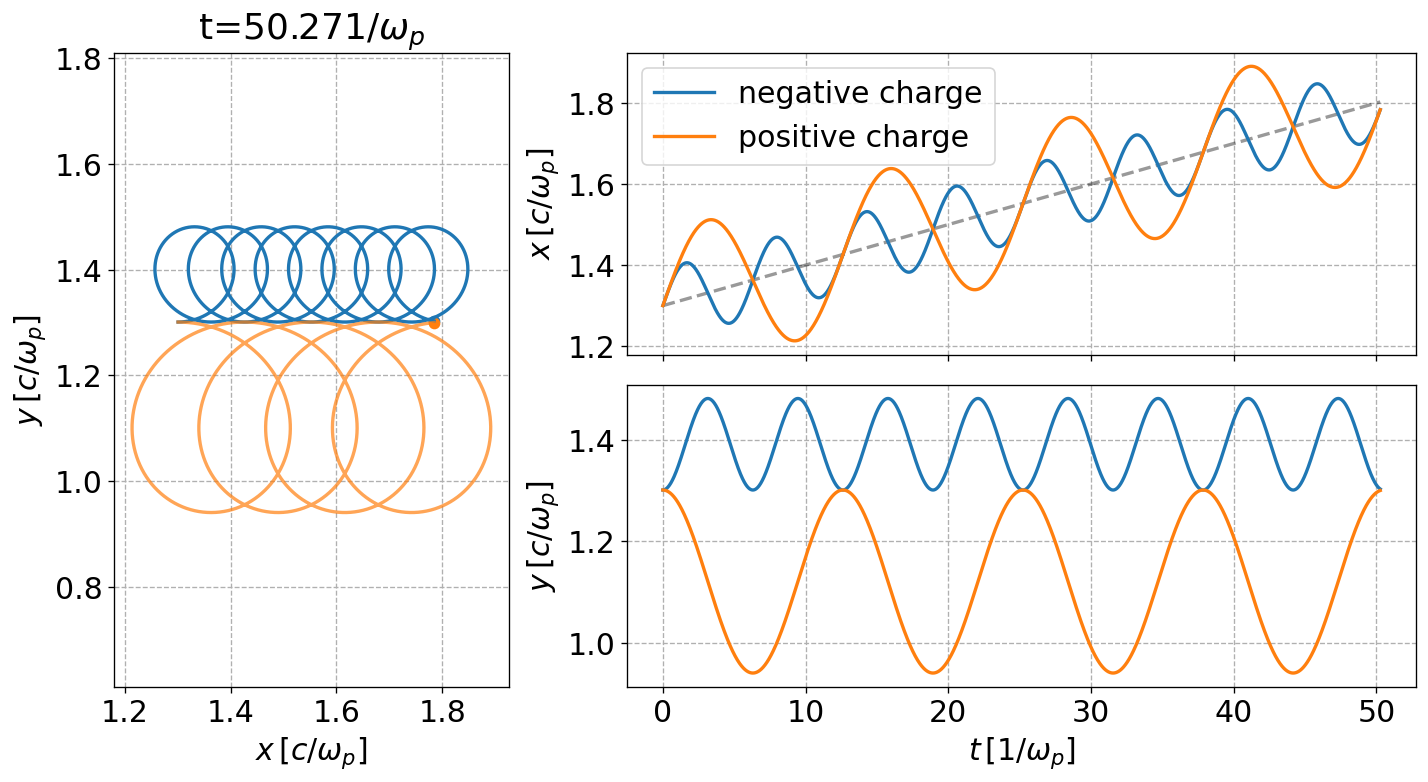

In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

#Set up the plot
fig=plt.figure(figsize=(14, 7), dpi=120)
plt.rcParams.update({'font.size': 18})
gs2 = gridspec.GridSpec(2, 2, hspace=0.1,width_ratios=[1, 2])

#left part: xy trajectories
ax = plt.subplot(gs2[:, 0])
## negative charge trajectory
ax.plot(e_posx_t,e_posy_t,lw=2)
ax.scatter(e_posx_t[-1],e_posy_t[-1])
## positive charge trajectory
ax.plot(p_posx_t,p_posy_t,lw=2,alpha=0.7)
ax.scatter(p_posx_t[-1],p_posy_t[-1])

#top right: xt trajectories
ax2 = plt.subplot(gs2[0,1])
ax2.plot(t,E[1]/B[2]*t+(p_posx_t[0]+e_posx_t[0])/2,lw=2,c='k',ls='--',alpha=0.4)
ax2.plot(t,e_posx_t,lw=2,label="negative charge")
ax2.plot(t,p_posx_t,lw=2,label="positive charge")

#bottom right: yt trajectories
ax3 = plt.subplot(gs2[1,1])
ax3.plot(t,e_posy_t,lw=2)
ax3.plot(t,p_posy_t,lw=2)

##setup labels, grids, and others
ax.grid(True,ls="--")
ax.set_xlabel("$x\,[c/\omega_p]$")
ax.set_ylabel("$y\,[c/\omega_p]$")
ax.set_aspect('equal', 'datalim')
ax.set_title("t={:.2f}$1/\omega_p$".format(sim.t))

ax2.set_xticklabels([])
ax2.grid(True,ls="--")
ax2.set_ylabel("$x\,[c/\omega_p]$")
ax2.legend()

ax3.set_ylabel("$y\,[c/\omega_p]$")
ax3.set_xlabel("$t\,[1/\omega_p]$")
ax3.grid(True,ls="--")

plt.show()

***
***

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from IPython.display import HTML

import numpy as np
from matplotlib import pyplot as plt

from matplotlib.animation import FuncAnimation
#fig, axes = plt.subplots(2)
# Create plot

fig=plt.figure(figsize=(8, 4),dpi=120)
plt.rcParams.update({'font.size': 9})

gs2 = gridspec.GridSpec(2, 2, hspace=0.1,width_ratios=[1, 2])

ax = plt.subplot(gs2[:, 0],xlim=(1.18,1.9),ylim=(0.6,1.8))

## guiding centers
linegg,=ax.plot([],[],lw=2,c="k",ls="--",alpha=0.4)
pointgg=ax.scatter([],[],c="k",alpha=0.4,marker="s")

linegg2,=ax.plot(E[1]/B[2]*t+p_posx_t[0],np.ones(sim.n)*(max(p_posy_t)+min(p_posy_t))/2,lw=2,c="k",ls="--",alpha=0.4)
pointgg2=ax.scatter([],[],c="k",alpha=0.4,marker="s")


line1,=ax.plot([],[],lw=2,alpha=0.7,c="C0")
point1=ax.scatter([],[],color="C0")

line2,=ax.plot([],[],lw=2,alpha=0.7,c="C1")
point2=ax.scatter([],[],color="C1")

ax.grid(True,ls="--")
ax.set_xlabel("$x\,[c/\omega_p]$")
ax.set_ylabel("$y\,[c/\omega_p]$")
ax.set_aspect('equal')



ax2 = plt.subplot(gs2[0,1],xlim=(0,t[-1]),ylim=(1.18,1.9))                                    
lineg,=ax2.plot([],[],lw=2,c='k',ls='--',alpha=0.4)
line3,=ax2.plot([],[],lw=2,label="negative charge",c="C0")
line4,=ax2.plot([],[],lw=2,label="positive charge",c="C1")
ax2.legend(loc=2)

ax2.set_xticklabels([])
ax2.grid(True,ls="--")
ax2.set_ylabel("$x\,[c/\omega_p]$")


ax3 = plt.subplot(gs2[1,1],xlim=(0,t[-1]),ylim=(0.6,1.8))
line5,=ax3.plot([],[],lw=2,c="C0")
line6,=ax3.plot([],[],lw=2,c="C1")
ax3.set_ylabel("$y\,[c/\omega_p]$")
ax3.set_xlabel("$t\,[1/\omega_p]$")
ax3.grid(True,ls="--")


def init():
    line1.set_data([],[])
    return line1,
plt.close(fig)
def animate(j):   
    i=10*j
    linegg.set_data(E[1]/B[2]*t[:i]+e_posx_t[0],np.ones(i)*(max(e_posy_t)+min(e_posy_t))/2)
    linegg2.set_data(E[1]/B[2]*t[:i]+p_posx_t[0],np.ones(i)*(max(p_posy_t)+min(p_posy_t))/2)
    pointgg.set_offsets((E[1]/B[2]*t[i]+e_posx_t[0],(max(e_posy_t)+min(e_posy_t))/2))
    pointgg2.set_offsets((E[1]/B[2]*t[i]+p_posx_t[0],(max(p_posy_t)+min(p_posy_t))/2))
    #print(i,"of",len(t-1))
    line1.set_data(e_posx_t[:i],e_posy_t[:i])
    point1.set_offsets((e_posx_t[i],e_posy_t[i]))

    line2.set_data(p_posx_t[:i],p_posy_t[:i])
    point2.set_offsets((p_posx_t[i],p_posy_t[i]))

    if(i%10==0):
        ax.set_title("t={:.2f}$1/\omega_p$".format(t[i]))

    line3.set_data(t[:i],e_posx_t[:i])
    line4.set_data(t[:i],p_posx_t[:i])
    lineg.set_data(t[:i],E[1]/B[2]*t[:i]+(e_posx_t[0]+p_posx_t[0])/2)
    line5.set_data(t[:i],e_posy_t[:i])
    line6.set_data(t[:i],p_posy_t[:i])
    print(i,"of",len(t),end="\r")
    return line1,

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=len(t)//10, interval=30, blit=True)

HTML(anim.to_html5_video())

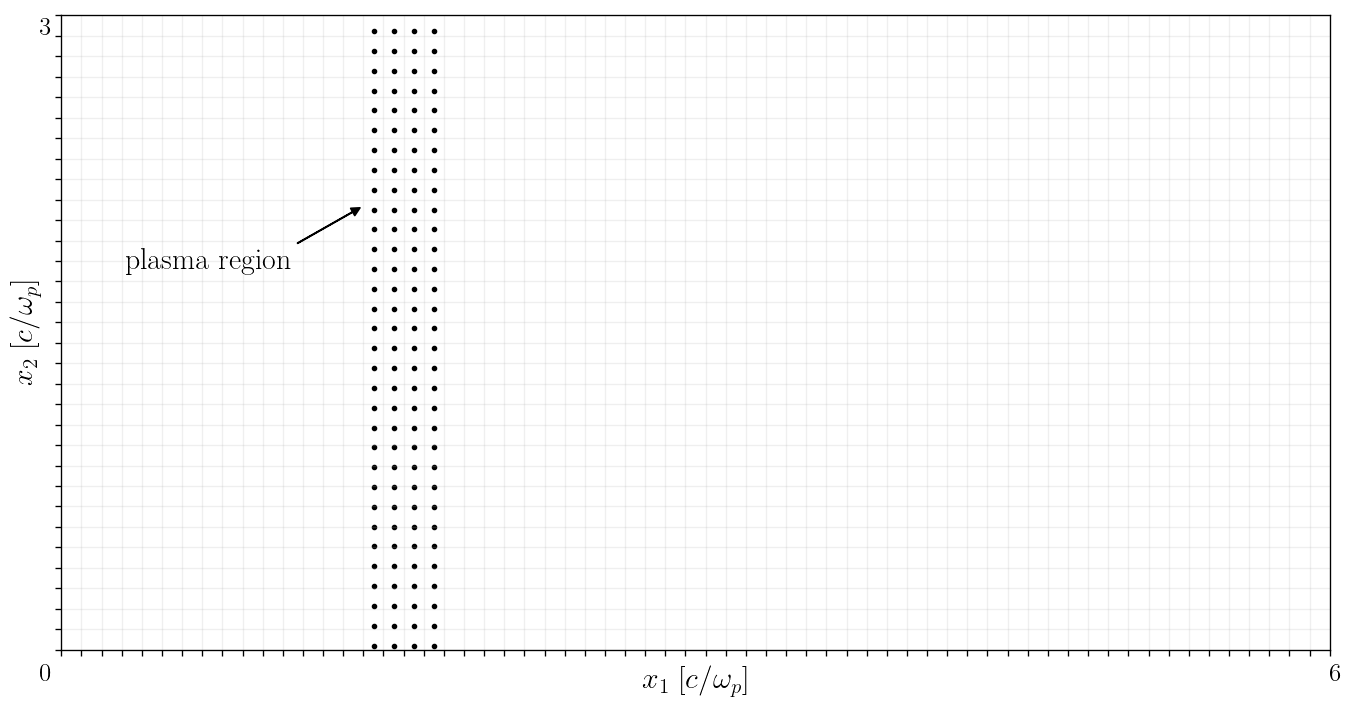

In [141]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(14, 7), dpi=120)
ax=plt.gca()
import matplotlib as mpl
plt.rcParams.update({'font.size': 18})

xese=(electrons.particles[:]['ix']+electrons.particles[:]['x'])*box[0]/nx[0]
yes=(electrons.particles[:]['iy']+electrons.particles[:]['y'])*box[0]/nx[0]
ax.scatter(xese,yes,s=5.5,c="k")


#ax.scatter(xese[64],yes[64],s=13,marker="s",c='red')
#ax.scatter(xese[56],yes[56],s=13,marker="s",c='red')


ax.set_xlim(0,box[0])
ax.set_ylim(0,box[1])
ax.set_xticks(np.linspace(0,box[0],nx[0]))
ax.set_yticks(np.linspace(0,box[1],nx[1]))
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.text(-0.1, -0.15, r'0', fontsize=15)
ax.text(6, -0.15, r'6', fontsize=15)
ax.text(-0.1, 2.91, r'3', fontsize=15)

ax.annotate('plasma region', xy=(1.43, 2.1), xytext=(0.3, 1.8),
            arrowprops=dict(facecolor='black', shrink=0.05,width=0.2,headwidth=5,headlength=5))


#ax.annotate('particle 64', xy=(1.43, 1.62), xytext=(0.3, 1.8),
#            arrowprops=dict(facecolor='black', shrink=0.05,width=0.2,headwidth=5,headlength=5))

ax.set_aspect('equal')
ax.grid(alpha=0.2)
ax.set_xlabel("$x_1\;[c/\omega_p]$")
ax.set_ylabel("$x_2\;[c/\omega_p]$")
plt.savefig("plasm.png")
#plt.savefig("part.png")